In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read the dataset
df=pd.read_csv("federal-candidates-2021-10-20.csv")

C:\Users\HP\AppData\Local\Temp\ipykernel_15324\2884330665.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("federal-candidates-2021-10-20.csv")


Since lgbtq_out, country_birth fewsture having more than 95% of missing values so we can drop these

In [3]:
data=df.copy()

In [4]:
# Added a new column age(the age of the candidate at the time of election) 
data['age'] = data['year'] - data['birth_year']

In [5]:
data = data.drop(['country_birth','lgbtq2_out','riding_id','birth_year' ],axis=1)

In [6]:
# filling the missing values in votes,percent votes with mean
for x in ['votes','percent_votes','age']:
    data[x] = data[x].fillna(data[x].mean())

    
# filling the missing values in catagorical colimns with mode
cols = ['incumbent','acclaimed','gender','occupation','lawyer','censuscategory']
for i in cols:
    
    data[i] = data[i].fillna(data[i].mode()[0])
      

In [7]:
data.isna().sum()

id                    0
parliament            0
year                  0
type_elxn             0
elected               0
candidate_name        0
edate                 0
incumbent             0
gender                0
indigenousorigins     0
occupation            0
lawyer                0
censuscategory        0
riding                0
province              0
votes                 0
percent_votes         0
acclaimed             0
switcher              0
multiple_candidacy    0
party_raw             0
party_minor_group     0
party_major_group     0
gov_party_raw         0
gov_minor_group       0
gov_major_group       0
num_candidates        0
age                   0
dtype: int64

In [8]:
Q1=np.percentile(data['votes'],25,interpolation='midpoint')
Q2=np.percentile(data['votes'],50,interpolation='midpoint')
Q3=np.percentile(data['votes'],75,interpolation='midpoint')


print(Q1)
print(Q2)
print(Q3)

1120.0
4205.0
10250.0


In [9]:
IQR=Q3-Q1
low_limit=Q1-1.5*IQR
up_limit=Q3+1.5*IQR
print(low_limit)
print(up_limit)

-12575.0
23945.0


In [10]:
outlier=[]
for x in data['votes']:
    if((x> up_limit) or (x<low_limit)):
        outlier.append(x)
ind=data['votes']>up_limit
data.loc[ind].index

Int64Index([ 6231,  8387,  8591,  8714,  9743, 10044, 10236, 10409, 10649,
            10763,
            ...
            46403, 46404, 46412, 46424, 46431, 46435, 46491, 46495, 46509,
            46517],
           dtype='int64', length=2118)

In [11]:
ind1 = data.loc[ind].index
data.drop(ind1,axis=0,inplace=True)

We can drop candidate name as well as the election date.Since we are provided with election year so we can delete the date field and candidate name which is not relavent for our future prediction

In [12]:
data = data.drop(['candidate_name','edate'],axis=1)

In [18]:
pd.set_option('display.max_columns',None)
data.head(2)

,id,parliament,year,type_elxn,elected,incumbent,gender,indigenousorigins,occupation,lawyer,censuscategory,riding,province,votes,percent_votes,acclaimed,switcher,multiple_candidacy,party_raw,party_minor_group,party_major_group,gov_party_raw,gov_minor_group,gov_major_group,num_candidates,age,e_month,e_day
0,26093,1,1867,General,Elected,Not incumbent,M,Other,merchant,Other,Sales and service occupations,HALIFAX,Nova Scotia,2367.0,26.125828,Not acclaimed,Switcher,Single,Anti-Confederate,Third_Party,Third_Party,Conservative,Conservative,Conservative,4,52.0,8,7
1,13011,1,1867,General,Elected,Not incumbent,M,Other,merchant,Other,Sales and service occupations,HALIFAX,Nova Scotia,2381.0,26.280354,Not acclaimed,Switcher,Single,Labour,Labour,Third_Party,Conservative,Conservative,Conservative,4,43.0,8,7


In [31]:
# Encoding the catagorical columns

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
col = ['type_elxn','elected','incumbent','gender','indigenousorigins','occupation',
       'lawyer','censuscategory','riding','province','acclaimed','switcher','multiple_candidacy','party_raw',
       'party_minor_group','party_major_group','gov_party_raw','gov_minor_group','gov_major_group']
for a in np.arange(len(col)):
    data[col[a]] = label_encoder.fit_transform(data[col[a]])

In [32]:
X = data.drop(['elected'],axis=1)
Y = data['elected']

In [17]:
# Scaling

from sklearn.preprocessing import StandardScaler
standard = StandardScaler()
X = standard.fit_transform(X)

In [22]:
X

array([[ 0.65710373, -2.31103827, -2.47240096, ...,  0.56894453,
         0.16734019, -1.24588851],
       [-0.46537072, -2.31103827, -2.47240096, ..., -1.24455417,
         0.16734019, -1.24588851],
       [ 0.81849911, -2.31103827, -2.47240096, ...,  0.00382246,
         0.16734019, -1.24588851],
       ...,
       [ 1.51032845,  1.33546049,  1.26241446, ...,  0.00382246,
         0.49579291,  0.29005868],
       [ 1.23738921,  1.33546049,  1.26241446, ...,  2.5839431 ,
         0.49579291,  0.29005868],
       [ 1.50638152,  1.33546049,  1.26241446, ...,  0.00382246,
         0.49579291,  0.29005868]])

In [33]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=45)


LOGISTIC REGRESSION

In [24]:
from sklearn.linear_model import LogisticRegression
logit_reg = LogisticRegression()
logit_reg.fit(X_train,Y_train)
Y_pred = logit_reg.predict(X_test)
Y_pred

array([0, 1, 0, ..., 1, 1, 0])

In [25]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,confusion_matrix


print("accuracy is:",accuracy_score(Y_test,Y_pred))
print("precision score:",precision_score(Y_test,Y_pred,average='macro'))
print("recall_score:",recall_score(Y_test,Y_pred,average='macro'))
print('f1 score:',f1_score(Y_test,Y_pred,average='macro'))

accuracy is: 0.9386399459581175
precision score: 0.9167431701129515
recall_score: 0.9147322063375263
f1 score: 0.9157316695983164


In [26]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [{'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [1, 10, 100, 1000],'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]
grid_search = GridSearchCV(estimator = logit_reg,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, Y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
108 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
ValueError: Sol

In [27]:
accuracy = grid_search.best_score_

In [28]:
accuracy

0.9371446264707538

In [29]:
# SVM

from sklearn.svm import SVC
svm_model = SVC(kernel='linear')
svm_model.fit(X_train,Y_train)
Y_pred = svm_model.predict(X_test)

In [30]:
print("accuracy is:",accuracy_score(Y_test,Y_pred))
confusion_matrix(Y_test,Y_pred)

accuracy is: 0.9413420400810628


array([[1848,  285],
       [ 236, 6513]], dtype=int64)

DESICION TREE

In [18]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,Y_train)
y_pred = dt_model.predict(X_test)

In [20]:

from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,confusion_matrix
print("accuracy is:",accuracy_score(Y_test,y_pred))
print("precision score:",precision_score(Y_test,y_pred,average='macro'))
print("recall_score:",recall_score(Y_test,y_pred,average='macro'))
print('f1 score:',f1_score(Y_test,y_pred,average='macro'))

accuracy is: 0.9968475568565638
precision score: 0.9955237283011376
recall_score: 0.9958413731068283
f1 score: 0.9956824306719503


[Text(0.6088814684139785, 0.96875, 'X[13] <= 49.994\ngini = 0.357\nsamples = 35526\nvalue = [8261, 27265]'),
 Text(0.2916876680107527, 0.90625, 'X[24] <= 49.098\ngini = 0.189\nsamples = 30486\nvalue = [3228, 27258]'),
 Text(0.05510752688172043, 0.84375, 'X[23] <= 2.5\ngini = 0.022\nsamples = 1612\nvalue = [1594, 18]'),
 Text(0.033602150537634407, 0.78125, 'X[12] <= 4666.382\ngini = 0.472\nsamples = 21\nvalue = [8, 13]'),
 Text(0.0228494623655914, 0.71875, 'gini = 0.0\nsamples = 13\nvalue = [0, 13]'),
 Text(0.04435483870967742, 0.71875, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.07661290322580645, 0.78125, 'X[13] <= 11.534\ngini = 0.006\nsamples = 1591\nvalue = [1586, 5]'),
 Text(0.06586021505376344, 0.71875, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.08736559139784947, 0.71875, 'X[2] <= 2019.5\ngini = 0.004\nsamples = 1589\nvalue = [1586, 3]'),
 Text(0.06586021505376344, 0.65625, 'X[13] <= 33.388\ngini = 0.001\nsamples = 1566\nvalue = [1565, 1]'),
 Text(0.055107526881

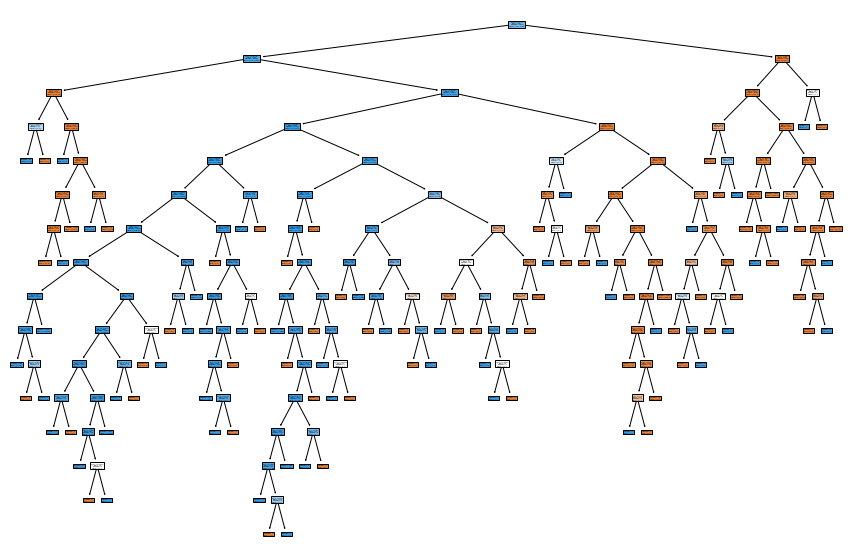

In [30]:
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(dt_model,filled=True)

In [22]:
path = dt_model.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [23]:
ccp_alphas

array([0.00000000e+00, 1.86142634e-05, 1.86920083e-05, 1.87588194e-05,
       1.87615292e-05, 1.87647599e-05, 2.41033606e-05, 2.50207985e-05,
       2.53335585e-05, 2.58026985e-05, 2.72687609e-05, 2.72954166e-05,
       2.75025830e-05, 2.78877650e-05, 2.80869444e-05, 2.81080008e-05,
       2.81304236e-05, 2.81483984e-05, 2.81483984e-05, 3.50934343e-05,
       4.26727681e-05, 4.36661051e-05, 4.42582587e-05, 4.50374374e-05,
       4.64288502e-05, 4.69139973e-05, 4.82543972e-05, 5.03708181e-05,
       5.27782469e-05, 5.54438149e-05, 5.56126300e-05, 5.61553406e-05,
       6.49716793e-05, 7.01681393e-05, 7.27877776e-05, 8.16668076e-05,
       1.10954639e-04, 1.12027842e-04, 1.57713788e-04, 2.38859266e-04,
       2.78803184e-04, 3.52327201e-04, 3.68439767e-04, 4.42624550e-04,
       7.83646740e-02, 1.94046204e-01])

In [25]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, Y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.19404620437741638


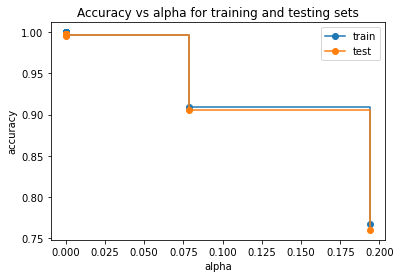

In [26]:
train_scores = [clf.score(X_train, Y_train) for clf in clfs]
test_scores = [clf.score(X_test, Y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [28]:
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.001)
clf.fit(X_train,Y_train)
pred=clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,pred)

0.9961720333258275

[Text(0.6, 0.875, 'X[13] <= 49.994\ngini = 0.357\nsamples = 35526\nvalue = [8261, 27265]'),
 Text(0.4, 0.625, 'X[24] <= 49.098\ngini = 0.189\nsamples = 30486\nvalue = [3228, 27258]'),
 Text(0.2, 0.375, 'gini = 0.022\nsamples = 1612\nvalue = [1594, 18]'),
 Text(0.6, 0.375, 'X[24] <= 49.598\ngini = 0.107\nsamples = 28874\nvalue = [1634, 27240]'),
 Text(0.4, 0.125, 'gini = 0.004\nsamples = 27271\nvalue = [58, 27213]'),
 Text(0.8, 0.125, 'gini = 0.033\nsamples = 1603\nvalue = [1576, 27]'),
 Text(0.8, 0.625, 'gini = 0.003\nsamples = 5040\nvalue = [5033, 7]')]

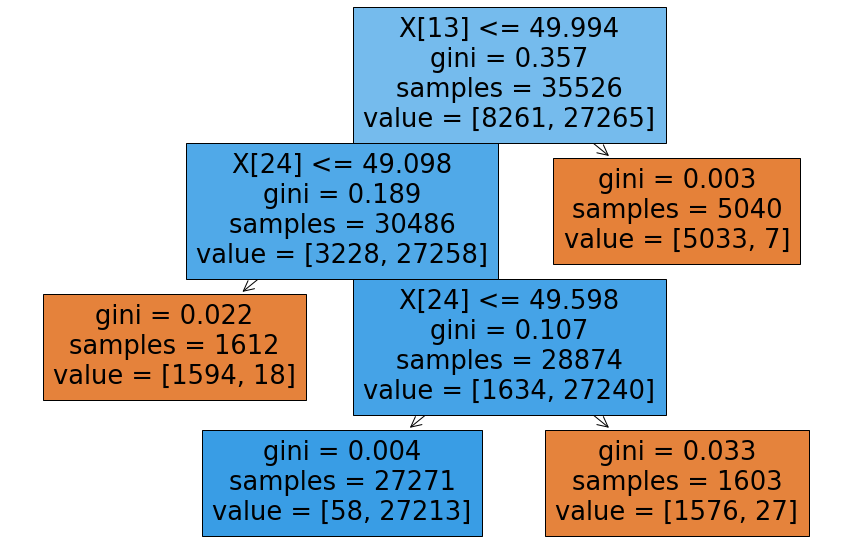

In [29]:
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(clf,filled=True)

RANDOM FOREST

In [34]:
from sklearn.ensemble import RandomForestClassifier

random = RandomForestClassifier(n_estimators=100)
random.fit(X_train,Y_train)
y_pred=random.predict(X_test)
y_pred

array([0, 1, 0, ..., 1, 1, 0])

In [36]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,confusion_matrix
print("accuracy is:",accuracy_score(Y_test,y_pred))
print("precision score:",precision_score(Y_test,y_pred,average='macro'))
print("recall_score:",recall_score(Y_test,y_pred,average='macro'))
print('f1 score:',f1_score(Y_test,y_pred,average='macro'))

accuracy is: 0.9976356676424228
precision score: 0.9962098381744234
recall_score: 0.9973219279173654
f1 score: 0.9967644133975788


In [34]:
confusion_matrix(Y_test,y_pred)

array([[2126,    7],
       [  15, 6734]], dtype=int64)

In [38]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [40]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = random,
                           param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap},
                           scoring = 'accuracy',
                           cv = 3,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, Y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [41]:
accuracy = grid_search.best_score_

In [42]:
accuracy

0.9848843100827563

In [1]:
## using Random Forest classifier to predict the data with highest accuracy.